In [1]:
import shutil
import time

import matplotlib.pyplot as plt
from fsspec.implementations.local import LocalFileSystem
from dask import delayed
from dask.distributed import Client, LocalCluster

from dummy_baskets import generate_dummy_baskets, run_index_basket_upload_test
from weave.index.index_pandas import IndexPandas
from weave.index.index_sqlite import IndexSQLite
from weave import Pantry

**Pandas Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type)**

In these tests we will be analyzing the performance differences when more files are uploaded, files are larger, and the number of basket types are increased. This will done using the pandas index.

In [2]:
pantry_pandas = Pantry(IndexPandas, pantry_path="dummy_pantry", file_system=LocalFileSystem())

In [3]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
pandas_time1 = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_pandas)
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type: {pandas_time1} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

1000 baskets, 1 upload file, 1 mb size files, 1 basket type: 162.09683966636658 seconds


In [4]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=10, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
pandas_time2 = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_pandas)
print(f"1000 baskets, 10 upload files, 1 mb size files, 1 basket type: {pandas_time2} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

1000 baskets, 10 upload files, 1 mb size files, 1 basket type: 169.64895677566528 seconds


Performance difference between uploading 10 files in each basket compared to 1 file in each basket

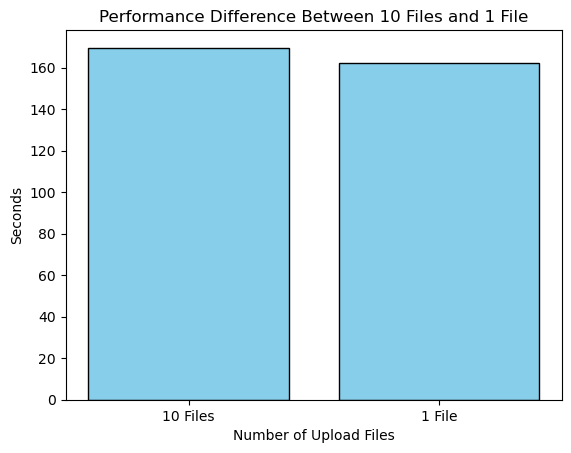

In [5]:
categories = ["10 Files", "1 File"]
values = [pandas_time2, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Number of Upload Files')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 10 Files and 1 File')

plt.show()

As you can see there is almost no difference in performance when we upload multiple files in each basket compared to one file

In [6]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=2, file_path="dummy_txt", num_basket_types=1)
pandas_time3 = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_pandas)
print(f"1000 baskets, 1 upload file, 2 mb size files, 1 basket type: {pandas_time3} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

1000 baskets, 1 upload file, 2 mb size files, 1 basket type: 161.73475551605225 seconds


Performance difference between uploading a 2 mb file in each basket compared to a 1 mb file in each basket

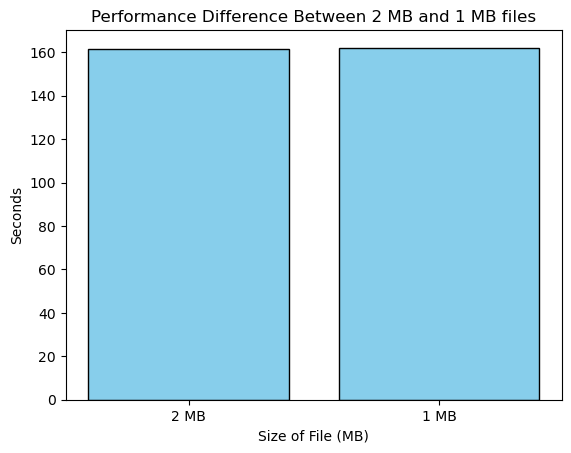

In [7]:
categories = ["2 MB", "1 MB"]
values = [pandas_time3, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Size of File (MB)')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 2 MB and 1 MB files')

plt.show()

Once again, there is almost no performance difference between uploading a 2 MB file and a 1 MB file in each basket

In [8]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=10)
pandas_time4 = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_pandas)
print(f"1000 baskets, 1 upload file, 1 mb size files, 10 basket types: {pandas_time4} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")

1000 baskets, 1 upload file, 1 mb size files, 10 basket types: 211.10540175437927 seconds


Performance difference between uploading 10 basket types versus 1 basket types

Text(0.5, 1.0, 'Performance Difference Between 10 and 1 Basket Types')

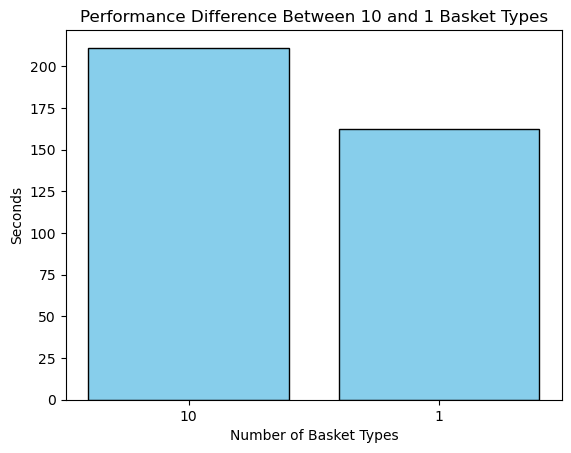

In [9]:
categories = ["10", "1"]
values = [pandas_time4, pandas_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Number of Basket Types')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 10 and 1 Basket Types')

Once again, there seems to be no performance difference between number of basket types

**SQLite Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type)**

In this test we will test the performance of uploading baskets using the same parameters as the first index pandas test. We will be using the SQLite index backend for these tests.

In [10]:
pantry_sqlite = Pantry(IndexSQLite, pantry_path="dummy_pantry", file_system=LocalFileSystem())

In [11]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)
sqlite_time1 = run_index_basket_upload_test(basket_list=baskets, pantry=pantry_sqlite)
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type: {sqlite_time1} seconds")
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")
pantry_sqlite.index.drop_index()

1000 baskets, 1 upload file, 1 mb size files, 1 basket type: 47.25689697265625 seconds


Performance difference between the Pandas Index and the SQLite index

Text(0.5, 1.0, 'Performance Difference Between Pandas and SQLite Indexes')

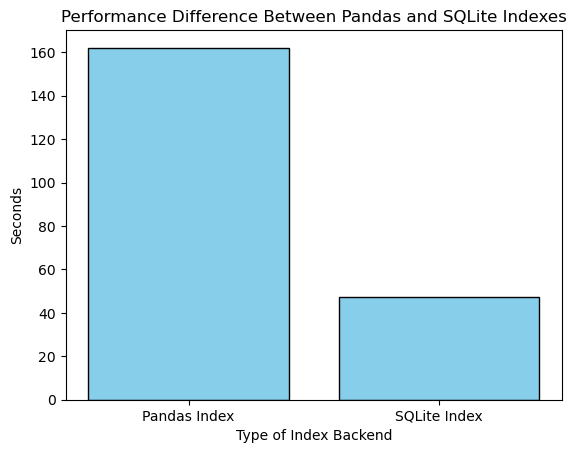

In [12]:
categories = ["Pandas Index", "SQLite Index"]
values = [pandas_time1, sqlite_time1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Type of Index Backend')
plt.ylabel('Seconds')
plt.title('Performance Difference Between Pandas and SQLite Indexes')

From the graph we can see there is a huge performance difference between the pandas and sqlite indexes

**SQLite Index Test (1000 Baskets, 1 Upload File, 1 MB File Size, 1 Basket Type) with 5 concurrent processes**

In this test we will test the performance of uploading baskets using the same parameters as the first index pandas test. We will be using the SQLite index backend with 5 concurrent processes for these tests.

In [13]:
pantry_sqlite_con = Pantry(IndexSQLite, pantry_path="dummy_pantry", file_system=LocalFileSystem())

In [14]:
# Set up a local cluster and client with 5 concurrent processes
cluster = LocalCluster(n_workers=5, threads_per_worker=1, processes=True)
client = Client(cluster)

In [15]:
baskets = generate_dummy_baskets(basket_count=1000, file_count=1, file_size_mb=1, file_path="dummy_txt", num_basket_types=1)

# Create a delayed function to upload all of our chunks
@delayed
def upload_chunk(chunk):
    pantry = Pantry(IndexSQLite, pantry_path="dummy_pantry", file_system=LocalFileSystem())
    run_index_basket_upload_test(chunk, pantry)

# Create 5 equal chunks each with 200 baskets
chunks = [baskets[i:i+200] for i in range(0, len(baskets), 200)]

# Upload all chunks in parallel
delayed_uploads = [upload_chunk(chunk) for chunk in chunks]

start_time = time.time()
results = client.compute(delayed_uploads, sync=True)
end_time = time.time()
sqlite_time_con1 = end_time - start_time
print(f"1000 baskets, 1 upload file, 1 mb size files, 1 basket type, 5 concurrent processes: {sqlite_time_con1} seconds")

1000 baskets, 1 upload file, 1 mb size files, 1 basket type, 5 concurrent processes: 19.64332151412964 seconds


Let's test that our index contains the correct number of baskets and basket types

In [16]:
pandas_index_df = pantry_sqlite_con.index.to_pandas_df()
print(f"Total number of baskets in index: {len(pandas_index_df)}")
print(f"Total number of unique uuids in index: {pandas_index_df["uuid"].nunique()}")


Total number of baskets in index: 1000
Total number of unique uuids in index: 1000


These values should both be 1000 so the index has been uploaded correctly

Cleanup our test files and pantry

In [17]:
shutil.rmtree("dummy_txt")
shutil.rmtree("dummy_pantry")
pantry_sqlite_con.index.drop_index()

Performance Difference Between 1 and 5 Concurrent Processes Using the SQLite Index

Text(0.5, 1.0, 'Performance Difference Between 1 and 5 Concurrent Processes Using the SQLite Index')

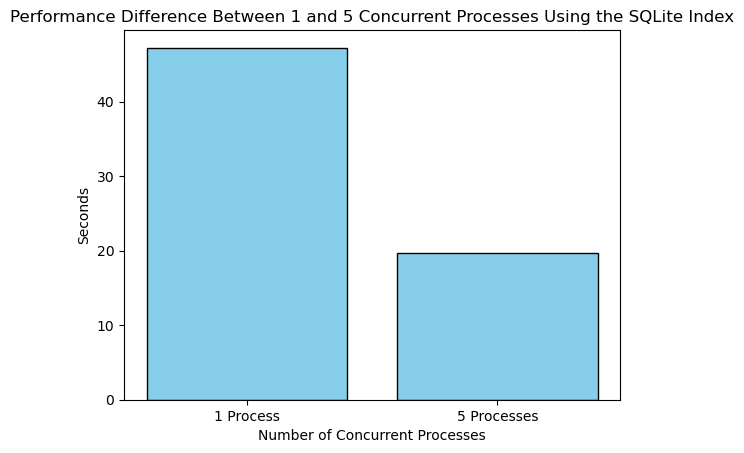

In [18]:
categories = ["1 Process", "5 Processes"]
values = [sqlite_time1, sqlite_time_con1]

plt.bar(categories, values, color='skyblue', edgecolor='black')

plt.xlabel('Number of Concurrent Processes')
plt.ylabel('Seconds')
plt.title('Performance Difference Between 1 and 5 Concurrent Processes Using the SQLite Index')